# InSAR denoiser training, validation

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns
import math
from skimage.metrics import structural_similarity as ssim
import random

## Dataset construction

In [2]:
# set paths
signal_dir = '/home/jovyan/InSAR_denoising_CNN/subsets_v2/veloc/'
noise_dir = '/home/jovyan/InSAR_denoising_CNN/subsets_v2/int/'
dem_dir = '/home/jovyan/InSAR_denoising_CNN/subsets_v2/dem/'
era5_dir = '/home/jovyan/InSAR_denoising_CNN/subsets_v2/era5/'

# list files
signal_fns = os.listdir(signal_dir)
noise_fns = os.listdir(noise_dir)
dem_fns = os.listdir(dem_dir)
era5_fns = os.listdir(era5_dir)

# exclude non tif files, e.g. metadata
def list_tifs(my_fns):
    my_list = []
    for i in my_fns:
        if i[-4:] == '.tif':
            my_list.append(i)
    return my_list

signal_list = list_tifs(signal_fns)
noise_list = list_tifs(noise_fns)
dem_list = list_tifs(dem_fns)
era5_list = list_tifs(era5_fns)


# create training list of only scenes shared in all necessary dirs
train_list = []
for fn in signal_list:
    if fn in noise_list and fn in dem_list and fn in era5_list:
        train_list.append(fn)

In [3]:
# split training and validation data 
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [4]:
# define transforms
my_transforms = transforms.Compose([
    transforms.ToTensor() #because label is also an image that needs to match, can't do any flipping
])

In [5]:
# define dataset 
class dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, signal_dir, noise_dir, dem_dir, era5_dir, transform=None, 
                 norm=True, center=True, invert=False, blurnoise=False, era5_corr=False):
        self.file_list = file_list
        self.transform = transform
        self.signal_dir = signal_dir
        self.noise_dir = noise_dir
        self.dem_dir = dem_dir
        self.era5_dir = era5_dir
        self.norm = norm
        self.center = center
        self.invert = invert
        self.blurnoise = blurnoise
        self.era5_corr = era5_corr
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load images
    def __getitem__(self,idx):
        signal_path = self.signal_dir+self.file_list[idx]
        noise_path = self.noise_dir+self.file_list[idx]
        dem_path = self.dem_dir+self.file_list[idx]
        era5_path = self.era5_dir+self.file_list[idx]
        
        signal = self.transform(Image.open(signal_path))
        noise = self.transform(Image.open(noise_path))
        dem = self.transform(Image.open(dem_path))
        era5 = self.transform(Image.open(era5_path))
        
        # Generate era5 noise estimates
        era5 = era5*(0.05546576/12.5663706) # convert phase to displacement
        era5 = (noise-(era5*-1)) 
        
        # Blur noise
        if self.blurnoise == True: # blur noise to mitigate noise from non atmospheric sources
            gblur = transforms.GaussianBlur(kernel_size=(7, 7), sigma=5)
            noise = gblur(noise)
        
        # Generate scaled training images
        scalar = np.round(np.random.lognormal(0.05, 1.), 3)
        signal = signal*scalar
        train = noise+signal
        
        # Set era reference point
        ref_index = signal.abs().argmin().item()
        corr_diff = (train.flatten()[ref_index] - era5.flatten()[ref_index]).item()
        era5 = era5+corr_diff
        
        if self.era5_corr == True:
            era5 = train-era5 #produce corrected train image instead of era5 noise estimate
        
        # normalization between -1 and 1 as in Zhao et al. https://doi.org/10.1016/j.isprsjprs.2021.08.009
        if self.norm == True:
            if train.min() < signal.min():
                norm_min = train.min()
            else:
                norm_min = signal.min()
                
            if train.max() > signal.max():
                norm_max = train.max()
            else:
                norm_max = signal.max()
            
            signal = 2*(((signal-(norm_min))/(norm_max-(norm_min))))-1
            noise  = 2*(((noise-(noise.min()))/(noise.max()-(noise.min()))))-1
            dem = 2*(((dem-dem.min())/(dem.max()-dem.min())))-1
            train = 2*(((train-(norm_min))/(norm_max-(norm_min))))-1
            
            if self.era5_corr == True:
                era5 = 2*(((era5-norm_min)/(norm_max-norm_min)))-1
            else: 
                era5 = 2*(((era5-era5.min())/(era5.max()-era5.min())))-1
        
        if self.center == True: # center target images on 0 
            center_median = signal.median()
            train = train-center_median
            signal = signal-center_median
            if self.era5_corr == True:
                era5 = era5-center_median
         
        # invert images to remove bias towards negative signal
        if self.invert == True:
            if random.random() < 0.5:
                train = train*-1
                signal = signal*-1
                noise = noise*-1
                era5 = era5*-1
        
        return train, signal, noise, era5, dem

In [6]:
# create dataloaders
train_data = dataset(train_list, signal_dir, noise_dir, dem_dir, era5_dir, transform=my_transforms, invert=False, blurnoise=True)
val_data = dataset(val_list, signal_dir, noise_dir, dem_dir, era5_dir, transform=my_transforms, invert=False, blurnoise=True)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=1, shuffle=True)

## Examine dataset

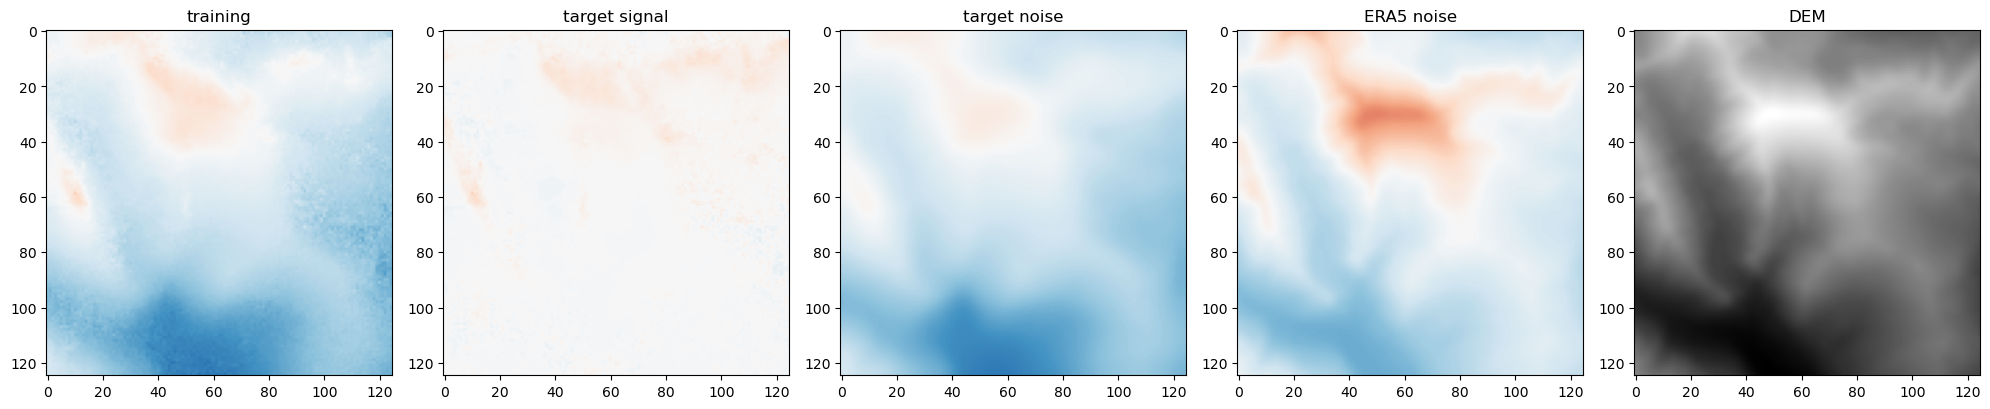

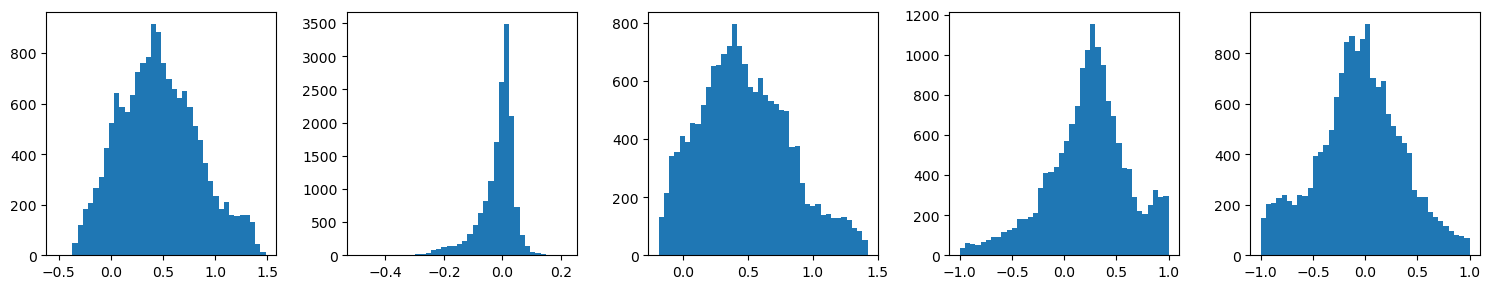

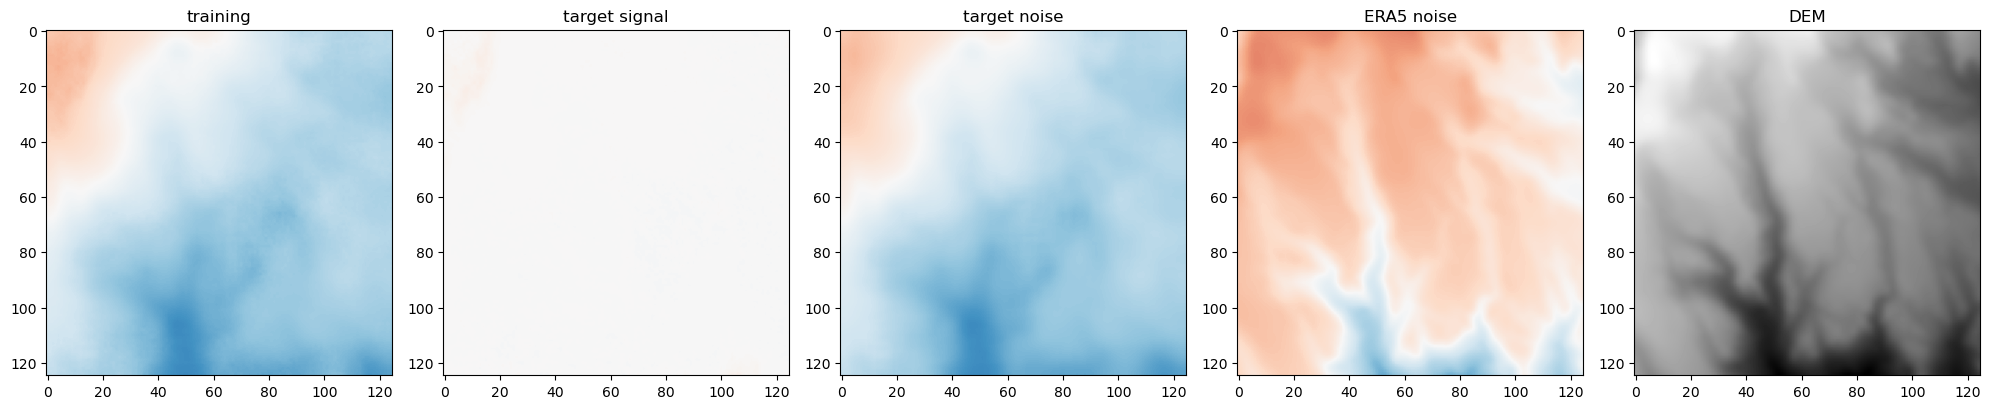

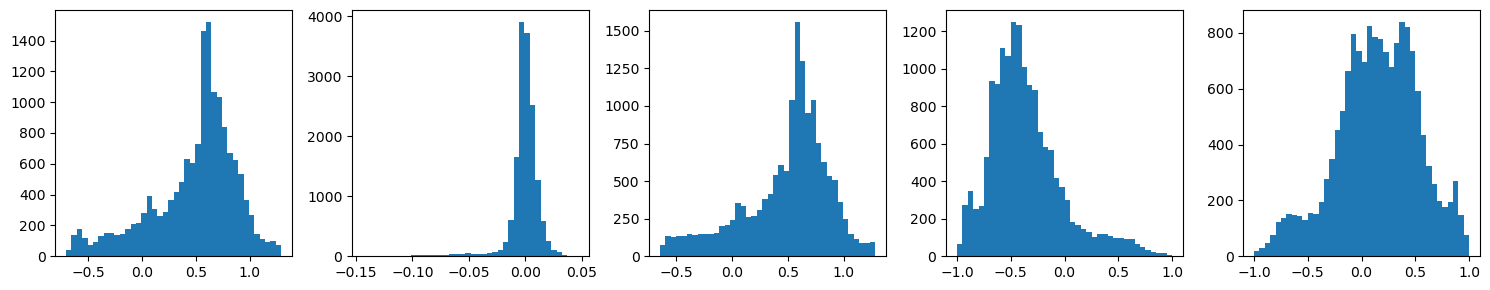

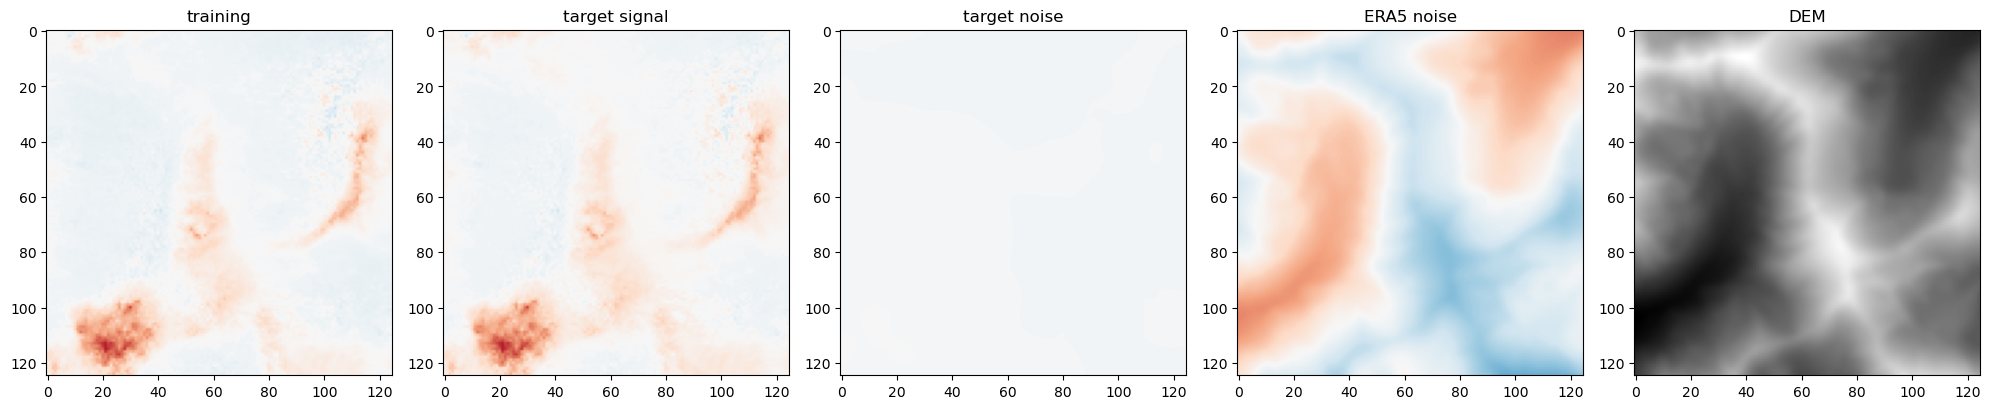

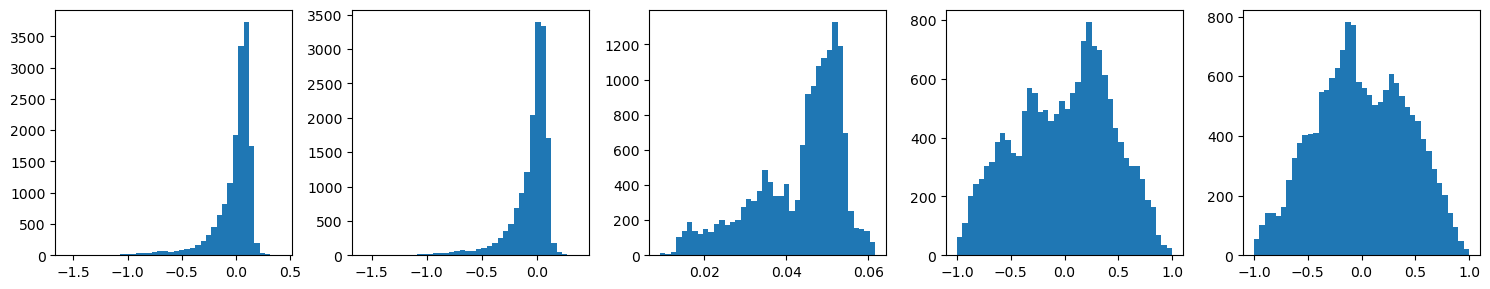

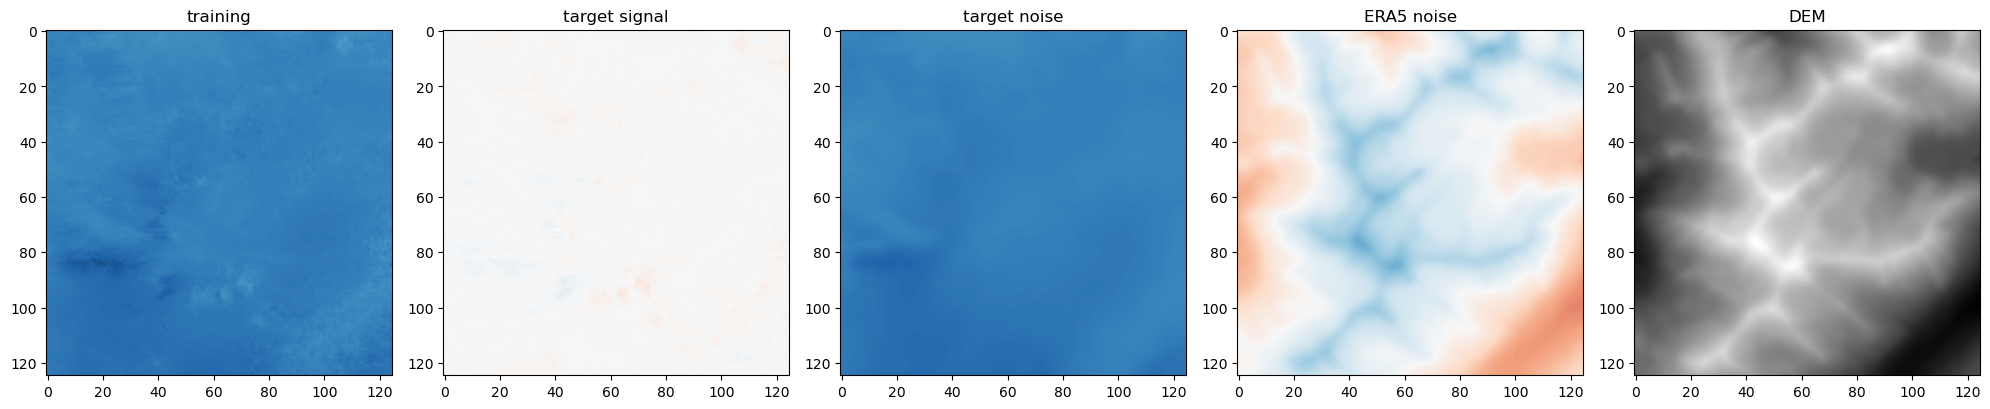

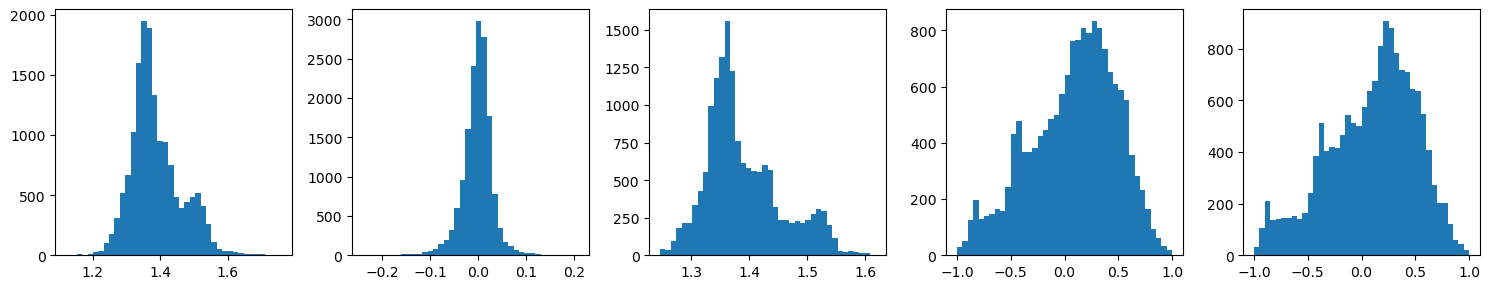

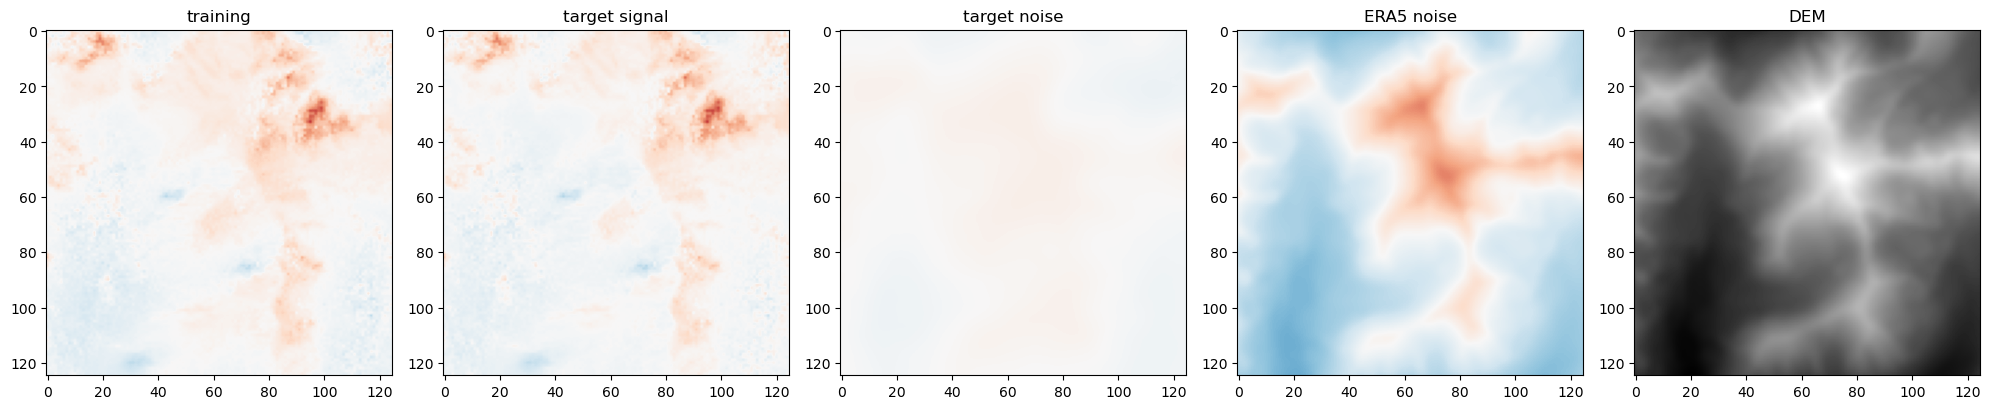

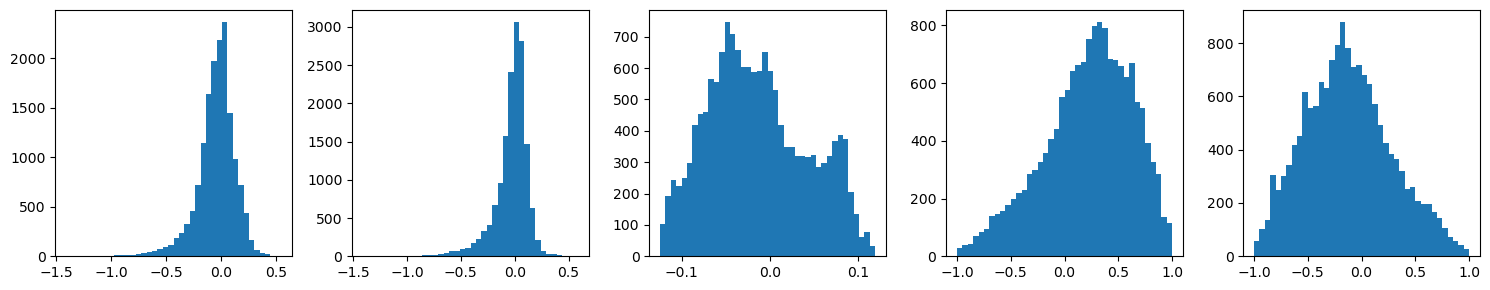

In [7]:
num_images = 5

for i, (sample, signal_target, noise_target, era5_noise, dem) in enumerate(val_loader):
    if i < num_images:
            f, ax = plt.subplots(1, 5, figsize=(20,7))
            ax[0].imshow(sample.squeeze(), cmap='RdBu', vmin=-2, vmax=2) 
            ax[0].set_title('training')
            ax[1].imshow(signal_target.squeeze(), cmap='RdBu', vmin=-2, vmax=2)
            ax[1].set_title('target signal')
            ax[2].imshow((sample.squeeze()-signal_target.squeeze()), cmap='RdBu', vmin=-2, vmax=2)
            ax[2].set_title('target noise')
            ax[3].imshow(era5_noise.squeeze(), cmap='RdBu', vmin=-2, vmax=2)
            ax[3].set_title('ERA5 noise')
            ax[4].imshow(dem.squeeze(), cmap='gray')
            ax[4].set_title('DEM')
            f.tight_layout()
            
            f, ax = plt.subplots(1, 5, figsize=(15,3))
            ax[0].hist(sum(sum(sum(sample.tolist(), []), []), []), bins=40)
            ax[1].hist(sum(sum(sum(signal_target.tolist(), []), []), []), bins=40)
            ax[2].hist(sum(sum(sum((sample-signal_target).tolist(), []), []), []), bins=40)
            ax[3].hist(sum(sum(sum(era5_noise.tolist(), []), []), []), bins=40)
            ax[4].hist(sum(sum(sum(dem.tolist(), []), []), []), bins=40)
            f.tight_layout()

## Define network

In [7]:
class DnCNN_noise(nn.Module):
    """
    Neural network model for InSAR denoising adapted from Rouet-Leduc et al., 2021
    """
    def __init__(self):
        super().__init__()
        kernel_size=3
        padding=1
        features=64
        channels=3
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 5
        self.cnn5 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=5, dilation=5)
        
         # Convolution 6
        self.cnn6 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=5, dilation=5)
        
        # Convolution 7
        self.cnn7 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 8
        self.cnn8 = nn.Conv2d(in_channels=features, out_channels=1, kernel_size=kernel_size, padding=padding)

    def forward(self, x, era5, dem):                
        # Set 1
        out = F.elu(self.cnn1(torch.cat((x, era5, dem), dim=1)), inplace=True) 
        
        # Set 2
        out = F.elu(self.cnn2(out), inplace=True) 
        
        # Set 3
        out = F.elu(self.cnn3(out), inplace=True)  
        
        # Set 4
        out = F.elu(self.cnn4(out), inplace=True) 
        
        # Set 5
        out = F.elu(self.cnn5(out), inplace=True)
        
        # Set 6
        out = F.elu(self.cnn6(out), inplace=True)
        
        # Set 7
        out = F.elu(self.cnn7(out), inplace=True)

        # Set 8
        out = self.cnn8(out)
        
        return out

## Train model

In [ ]:
%%time

#Define optimizer
model = DnCNN_noise()
model.to('cuda') # run on gpu
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # set learning rate
loss_fn   = nn.L1Loss() # MAE loss function, doesn't penalize outliers as much as MSE
epochs = 500
quantile = 0.9 # full loss computed for pixels with magnitude above this quantile 
stable_scalar = 0.01 # scalar for devaluing pixels with magnitude below quantile in loss calc
torch.autograd.set_detect_anomaly(True)

train_loss = []
valid_loss = []

for epoch in range(epochs):
    print(f'\nstarting epoch {epoch}')
    epoch_loss=[]
    valid_temp_loss = []
    
    if epoch == 100:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # reduce loss as given epoch
    
    #loop through training data 
    for (sample, signal_target, noise_target, era5_noise, dem) in train_loader:
        optimizer.zero_grad()
        out = torch.clamp(model(sample.to('cuda'), era5_noise.to('cuda'), dem.to('cuda')), -1, 1) # Generate noise predictions
        
        # isolate high-signal areas for loss calculation
        # find quantile values for given batch of images
        q = signal_target.to('cuda').abs().flatten(1, 3).quantile(dim=1, q=quantile, keepdim=True) 
        # scale down target values in pixels with magnitude below quantile for loss calc
        signal_target_high = torch.where(signal_target.to('cuda').abs()>q.to('cuda')[:, None, None], 
                                         signal_target.to('cuda'), signal_target.to('cuda')*stable_scalar)
        # calculate predicted signals 
        signal_pred = sample.to('cuda')-out.to('cuda')
        # scale down predicted signal values in pixels with magnitude below quantile for loss calc
        signal_pred_high = torch.where(signal_target.to('cuda').abs()>q.to('cuda')[:, None, None], 
                                       signal_pred.to('cuda'), signal_pred.to('cuda')*stable_scalar)
        
        loss = loss_fn(signal_pred_high.to('cuda'), signal_target_high.to('cuda')) # calculate loss 
        epoch_loss.append(loss.item()) # add batch loss to epoch loss list
        
        loss.backward() #Propagate the gradients in backward pass
        optimizer.step() 
    
    train_loss.append(np.mean(epoch_loss)) # add mean epoch loss to training loss list
    print(f'training loss: {np.mean(epoch_loss)}')
    
    # run model on validation data 
    for (sample, signal_target, noise_target, era5_noise, dem) in val_loader:
        with torch.no_grad():
            model.eval()
            out = torch.clamp(model(sample.to('cuda'), era5_noise.to('cuda'), dem.to('cuda')), -1, 1) #Generate predictions using the model
            
            # isolate high-signal areas for loss calculation
            q = signal_target.to('cuda').abs().flatten(1, 3).quantile(dim=1, q=quantile, keepdim=True)
            signal_target_high = torch.where(signal_target.to('cuda').abs()>q.to('cuda')[:, None, None], 
                                         signal_target.to('cuda'), signal_target.to('cuda')*stable_scalar)   
            signal_pred = sample.to('cuda')-out.to('cuda')
            signal_pred_high = torch.where(signal_target.to('cuda').abs()>q.to('cuda')[:, None, None], 
                                       signal_pred.to('cuda'), signal_pred.to('cuda')*stable_scalar)
            
            loss = loss_fn(signal_pred_high.to('cuda'), signal_target_high.to('cuda')) #Loss/error
            valid_temp_loss.append(loss.item())
    
    valid_loss.append(np.mean(valid_temp_loss))
    print(f'validation loss: {np.mean(valid_temp_loss)}')
    
    if (epoch+1)%50 == 0: 
        # save model
        torch.save(model.state_dict(), f'noisemodelv3.0_{epoch+1}epochs')


starting epoch 0
training loss: 0.022696865732551263
validation loss: 0.01682708224408538

starting epoch 1
training loss: 0.017236796558223744
validation loss: 0.01783987376007328

starting epoch 2
training loss: 0.016025533879636435
validation loss: 0.016743577170172805

starting epoch 3
training loss: 0.015893671281074963
validation loss: 0.015587369003088564

starting epoch 4
training loss: 0.015747570532864782
validation loss: 0.015333525410729297

starting epoch 5
training loss: 0.015494299321485463
validation loss: 0.015907307119689115

starting epoch 6
training loss: 0.015265484370531575
validation loss: 0.015584358660427216

starting epoch 7
training loss: 0.015312185380808127
validation loss: 0.016844962366141178

starting epoch 8
training loss: 0.015215373718209805
validation loss: 0.014769852040218766

starting epoch 9
training loss: 0.015200516569518274
validation loss: 0.014731694670108134

starting epoch 10
training loss: 0.014807188452812292
validation loss: 0.01464136

In [8]:
#load model
model = DnCNN_noise()
model.load_state_dict(torch.load('noisemodelv3.0_200epochs'))
model.to('cuda')

DnCNN_noise(
  (cnn1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(5, 5), dilation=(5, 5))
  (cnn6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(5, 5), dilation=(5, 5))
  (cnn7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn8): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## Examine results

NameError: name 'train_loss' is not defined

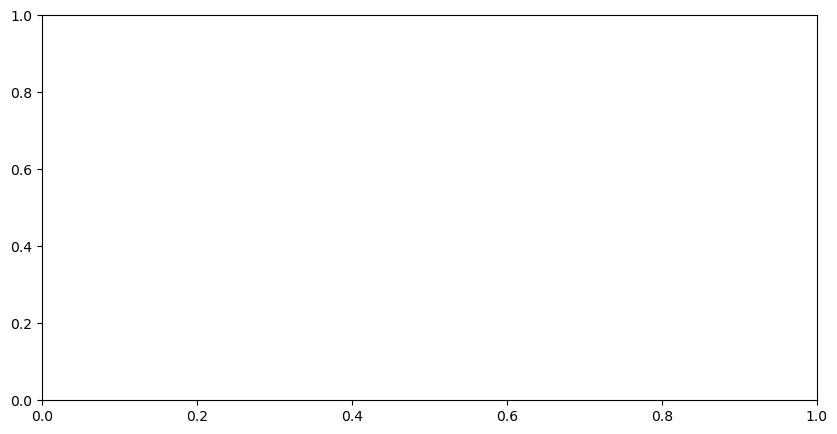

In [10]:
#plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(valid_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('L1 loss')
ax.set_title('Loss')
ax.legend()

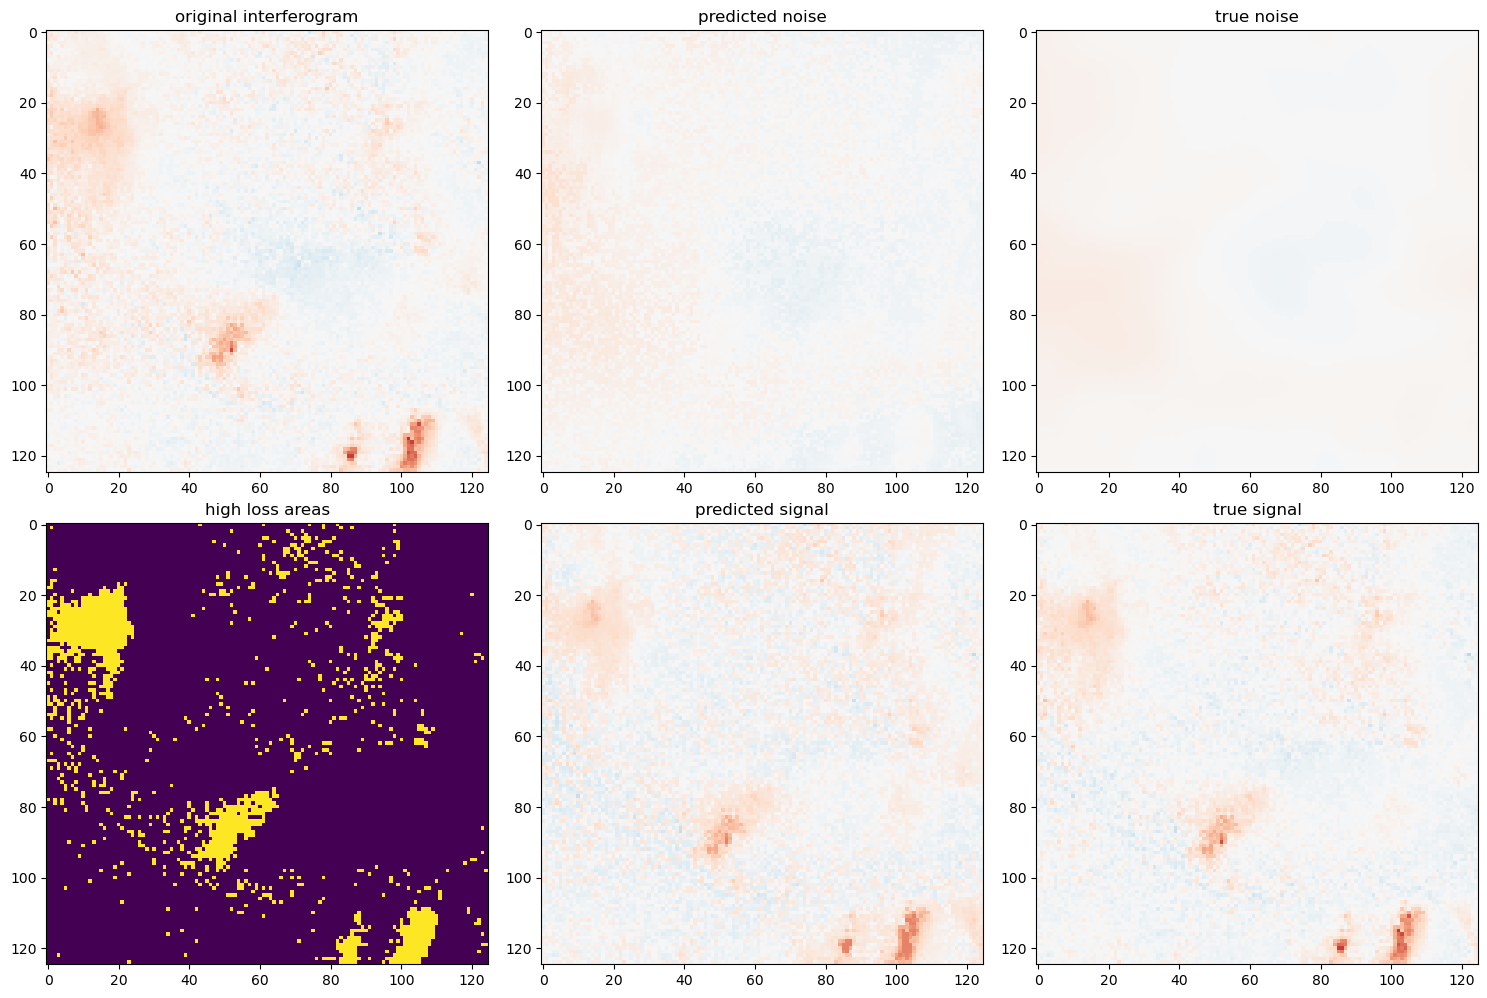

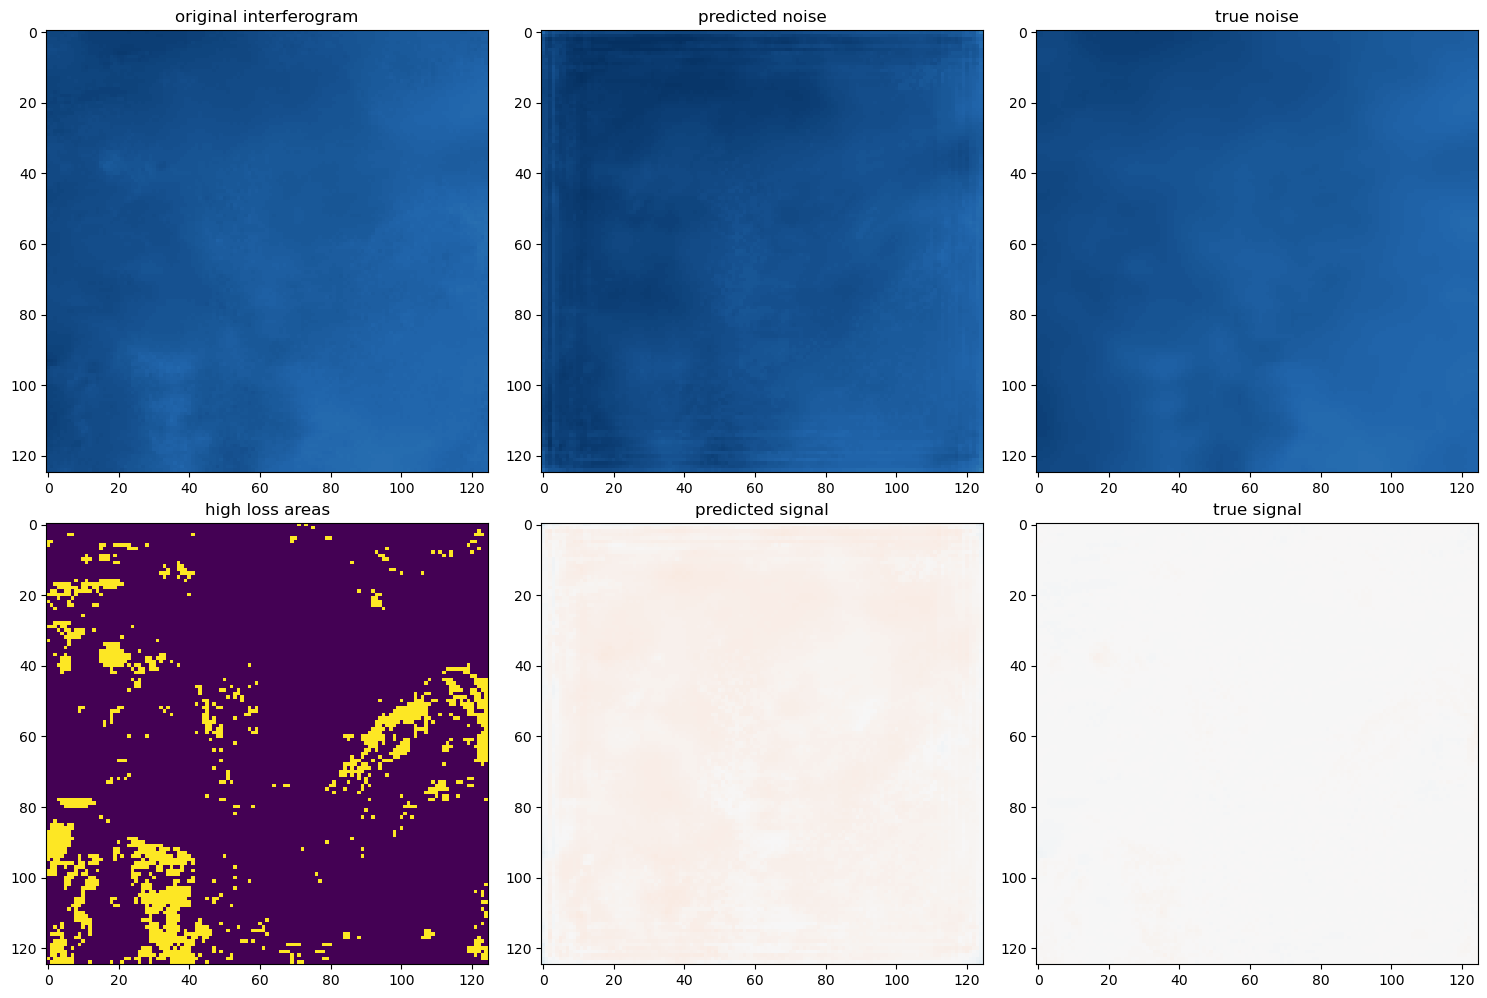

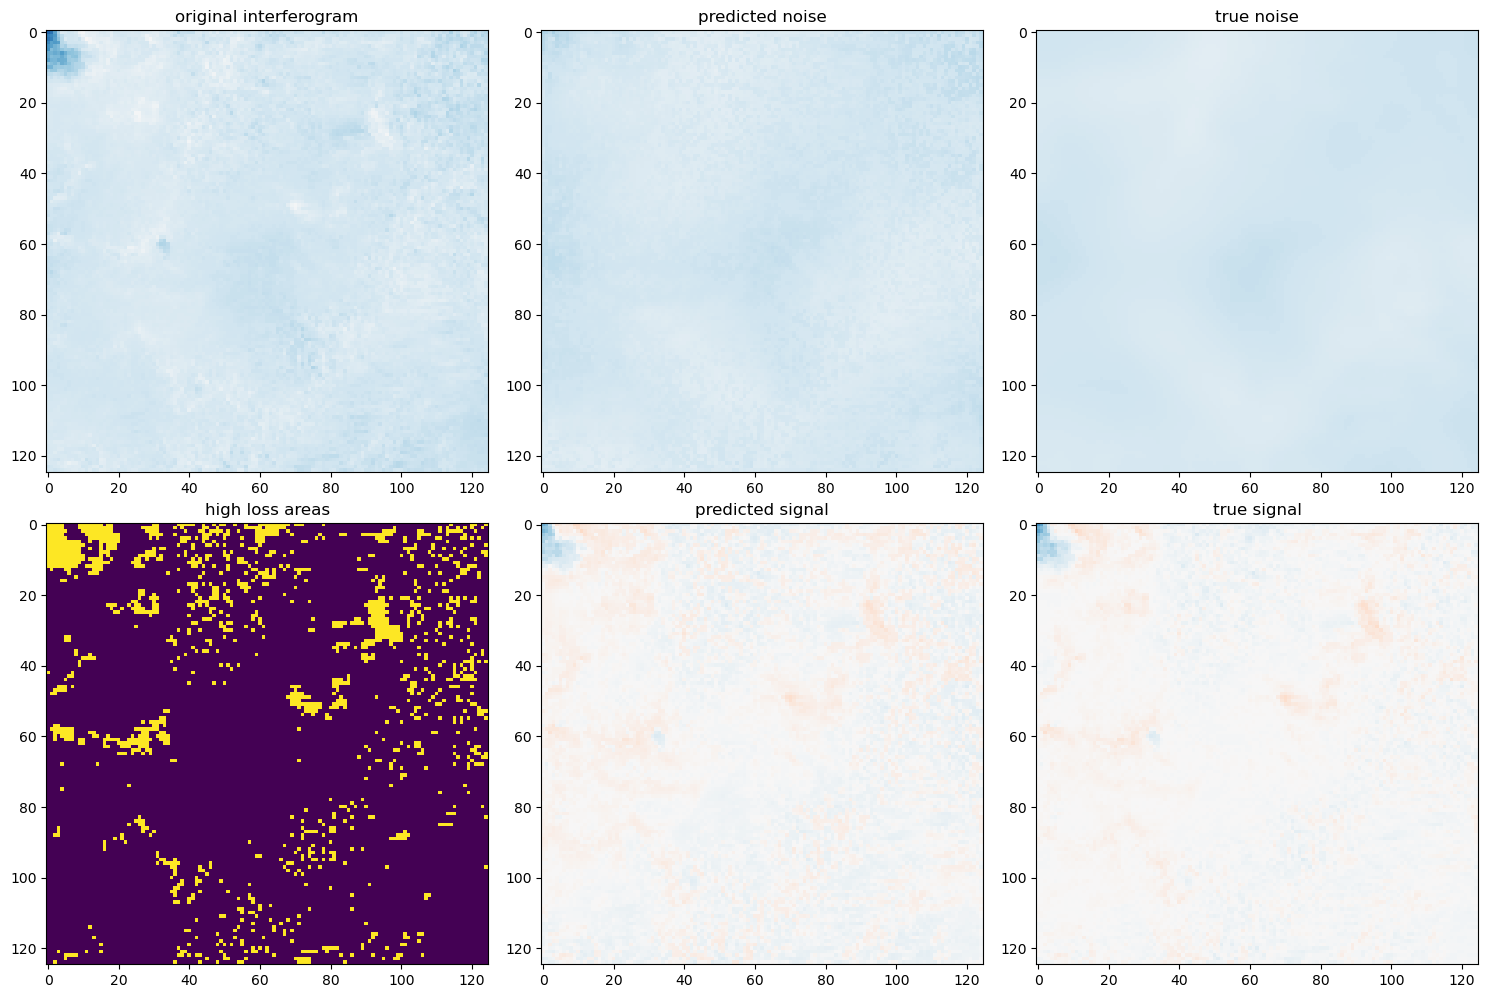

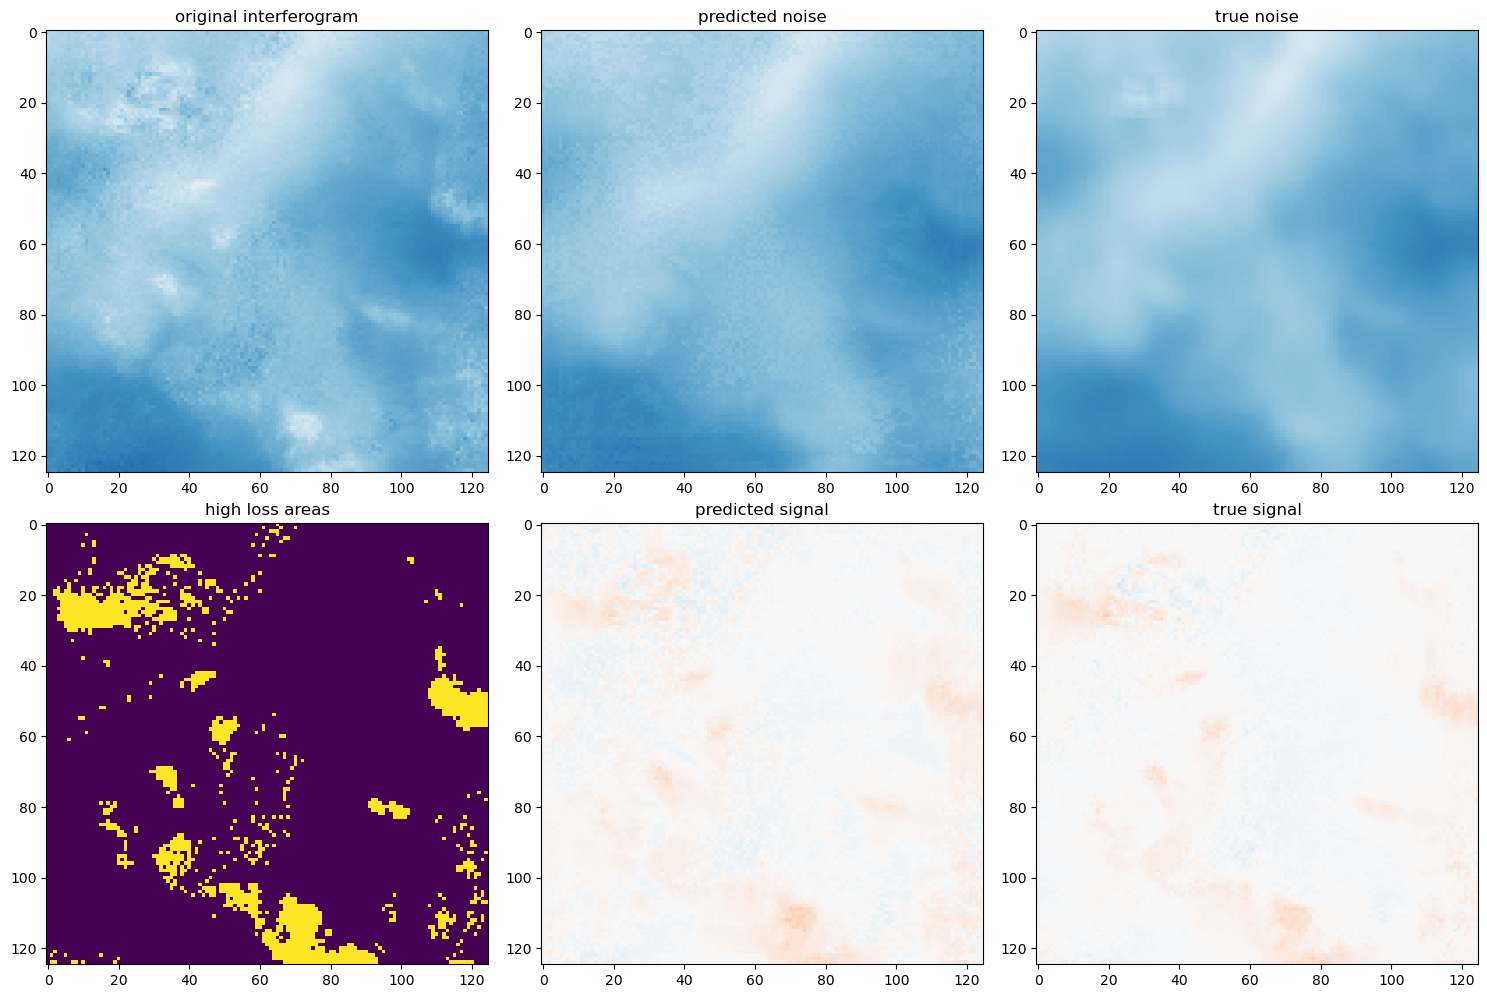

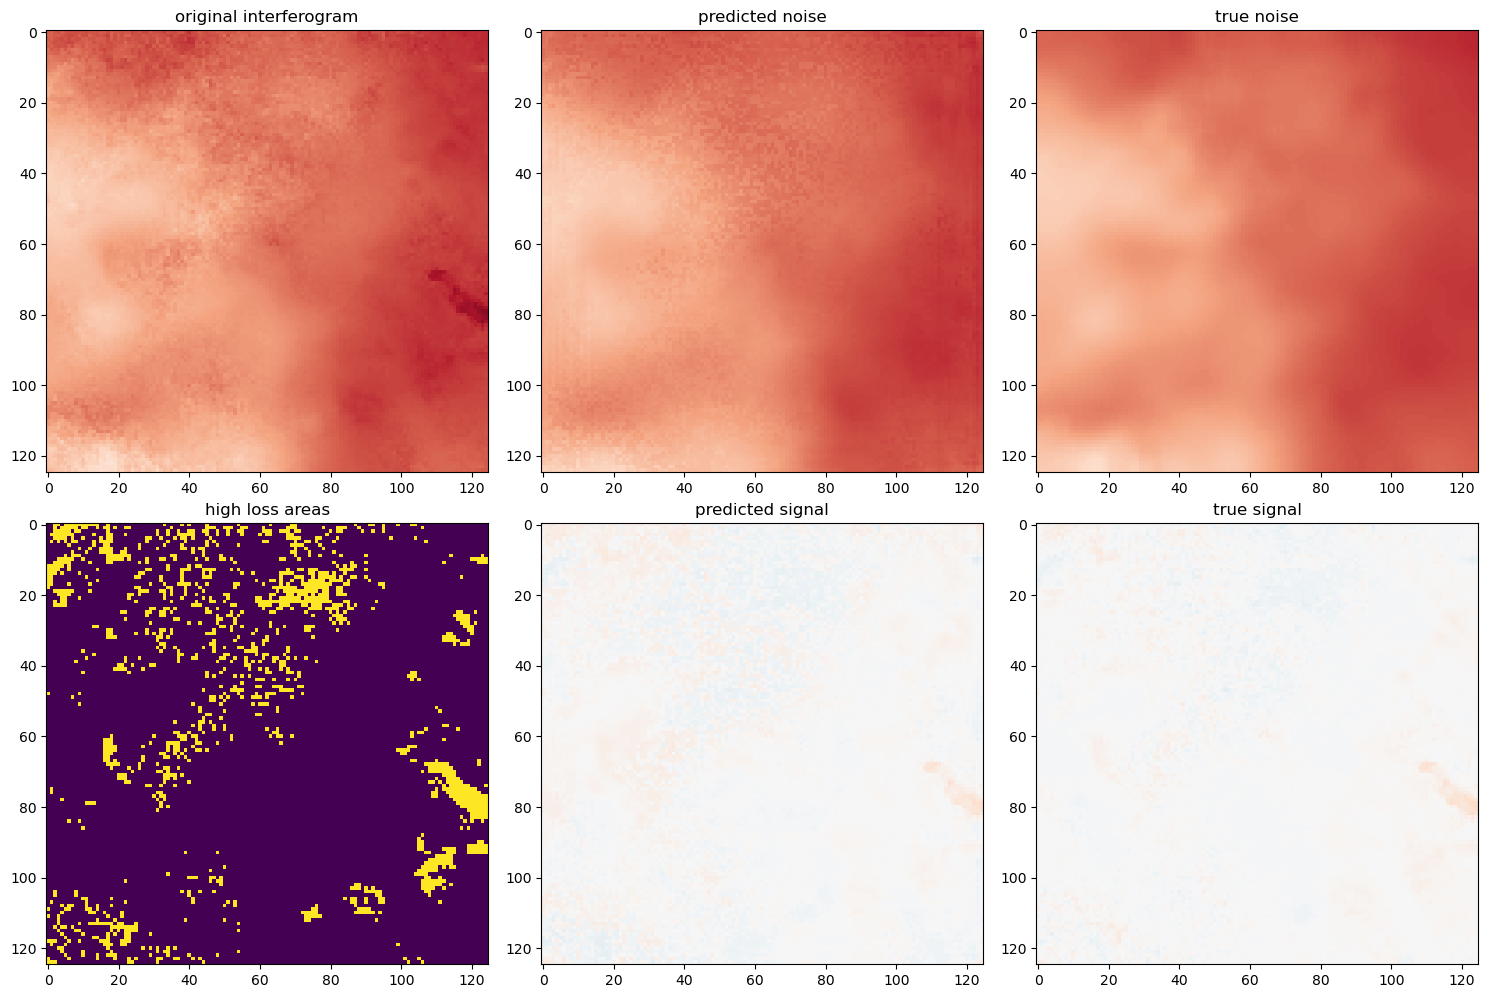

In [9]:
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=1, shuffle=True) #change batch size

num_images = 5
quantile = 0.90

for i, (sample, signal_target, noise_target, era5_noise, dem) in enumerate(val_loader):
    if i < num_images:
        with torch.no_grad():
            noise = model(sample.to('cuda'), era5_noise.to('cuda'), dem.to('cuda')) #Generate predictions using the model
            signal = torch.clamp(sample.to('cpu') - noise.to('cpu'), -1, 1)
            q = signal_target.to('cuda').abs().flatten(1, 3).quantile(dim=1, q=quantile, keepdim=True)
            signal_target_high = signal_target.to('cuda').abs()>q.to('cuda')[:, None, None]
            
            
            f, ax = plt.subplots(2, 3, figsize=(15,10))
            ax[0][0].imshow(sample.squeeze(), cmap='RdBu', vmin=-2, vmax=2) 
            ax[0][0].set_title('original interferogram')
            ax[0][1].imshow(noise.squeeze().to('cpu'), cmap='RdBu', vmin=-2, vmax=2)
            ax[0][1].set_title('predicted noise')
            ax[0][2].imshow((sample.squeeze()-signal_target.squeeze()), cmap='RdBu', vmin=-2, vmax=2)
            ax[0][2].set_title('true noise')
            ax[1][1].imshow(signal.squeeze(), cmap='RdBu', vmin=-2, vmax=2)
            ax[1][1].set_title('predicted signal')
            ax[1][2].imshow(signal_target.squeeze(), cmap='RdBu', vmin=-2, vmax=2)
            ax[1][2].set_title('true signal')
            ax[1][0].imshow(signal_target_high.squeeze().to('cpu'))
            ax[1][0].set_title('high loss areas')
            plt.tight_layout()

In [10]:
val_loader_ssim = torch.utils.data.DataLoader(dataset = val_data, batch_size=1, shuffle=False)
train_loader_ssim = torch.utils.data.DataLoader(dataset = train_data, batch_size=1, shuffle=False)

In [11]:
# Calculate SSIM
val_ssim_list_corrected = []
val_ssim_list_uncorrected = []

for i, (sample, signal_target, noise_target, era5_noise, dem) in enumerate(val_loader_ssim):
    val_noise = model(sample.to('cuda'), era5_noise.to('cuda'), dem.to('cuda')) #Generate predictions using the model
    val_signal = torch.clamp(sample.to('cpu') - val_noise.to('cpu'), -1, 1)
    val_ssim_value_corrected = ssim(val_signal.squeeze().detach().numpy(), signal_target.squeeze().detach().numpy(),
                         gaussian_weights=True)
    val_ssim_list_corrected.append(val_ssim_value_corrected)
    val_ssim_value_uncorrected = ssim(sample.squeeze().detach().numpy(), signal_target.squeeze().detach().numpy(),
                         gaussian_weights=True)
    val_ssim_list_uncorrected.append(val_ssim_value_uncorrected)
    
    
print('mean val ssim (before correction):', np.mean(val_ssim_list_uncorrected),
      '\nmean val ssim (after correction):', np.mean(val_ssim_list_corrected))

train_ssim_list_corrected = []
train_ssim_list_uncorrected = []

for i, (sample, signal_target, noise_target, era5_noise, dem) in enumerate(train_loader_ssim):
    train_noise = model(sample.to('cuda'), era5_noise.to('cuda'), dem.to('cuda')) #Generate predictions using the model
    train_signal = torch.clamp(sample.to('cpu') - train_noise.to('cpu'), -1, 1)
    train_ssim_value_corrected = ssim(train_signal.squeeze().detach().numpy(), signal_target.squeeze().detach().numpy(),
                         gaussian_weights=True)
    train_ssim_list_corrected.append(train_ssim_value_corrected)
    train_ssim_value_uncorrected = ssim(sample.squeeze().detach().numpy(), signal_target.squeeze().detach().numpy(),
                         gaussian_weights=True)
    train_ssim_list_uncorrected.append(train_ssim_value_uncorrected)
    
    
print('mean train ssim (before correction):', np.mean(train_ssim_list_uncorrected),
      '\nmean train ssim (after correction):', np.mean(train_ssim_list_corrected)) 

mean val ssim (before correction): 0.054931475022119196 
mean val ssim (after correction): 0.5376933725187666
mean train ssim (before correction): 0.05302817301415822 
mean train ssim (after correction): 0.5407123734644455


In [12]:
# Calculate SNR
def rms(tensor):
    rms = np.sqrt(np.mean(tensor.squeeze().numpy()**2))
    return rms

val_snr_list = []

for i, (sample, signal_target, noise_target, era5_noise, dem) in enumerate(val_loader_ssim):
    val_snr_list.append(rms(signal_target)/rms(sample-signal_target))
    

print('mean snr of val images:', np.mean(val_snr_list)) 

train_snr_list = []

for i, (sample, signal_target, noise_target, era5_noise, dem) in enumerate(train_loader_ssim):
    train_snr_list.append(rms(signal_target)/rms(sample-signal_target))
    

print('mean snr of train images:', np.mean(train_snr_list)) 

mean snr of val images: 0.3935306
mean snr of train images: 0.40482974


In [13]:
val_ssim_dict = {'snr': val_snr_list,
                 'ssim_uncorrected': val_ssim_list_uncorrected,
                 'ssim_corrected':val_ssim_list_corrected}
val_ssim_df = pd.DataFrame(val_ssim_dict)
val_ssim_df['ssim_uncorrected_median'] = val_ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(200, center=True).median()
val_ssim_df['ssim_corrected_median'] = val_ssim_df.sort_values(by=['snr']).ssim_corrected.rolling(200, center=True).median()
val_ssim_df['ssim_uncorrected_q25'] = val_ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(200, center=True).quantile(quantile=0.25)
val_ssim_df['ssim_corrected_q25'] = val_ssim_df.sort_values(by=['snr']).ssim_corrected.rolling(200, center=True).quantile(quantile=0.25)
val_ssim_df['ssim_uncorrected_q75'] = val_ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(200, center=True).quantile(quantile=0.75)
val_ssim_df['ssim_corrected_q75'] = val_ssim_df.sort_values(by=['snr']).ssim_corrected.rolling(200, center=True).quantile(quantile=0.75)

train_ssim_dict = {'snr':train_snr_list,
                   'ssim_uncorrected':train_ssim_list_uncorrected,
                   'ssim_corrected':train_ssim_list_corrected}
train_ssim_df = pd.DataFrame(train_ssim_dict)
train_ssim_df['ssim_uncorrected_median'] = train_ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(200, center=True).median()
train_ssim_df['ssim_corrected_median'] = train_ssim_df.sort_values(by=['snr']).ssim_corrected.rolling(200, center=True).median()
train_ssim_df['ssim_uncorrected_q25'] = train_ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(200, center=True).quantile(quantile=0.25)
train_ssim_df['ssim_corrected_q25'] = train_ssim_df.sort_values(by=['snr']).ssim_corrected.rolling(200, center=True).quantile(quantile=0.25)
train_ssim_df['ssim_uncorrected_q75'] = train_ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(200, center=True).quantile(quantile=0.75)
train_ssim_df['ssim_corrected_q75'] = train_ssim_df.sort_values(by=['snr']).ssim_corrected.rolling(200, center=True).quantile(quantile=0.75)


<AxesSubplot:title={'center':'After noise removal (training)'}, xlabel='SNR (signal/atmosphere)', ylabel='ssim_corrected'>

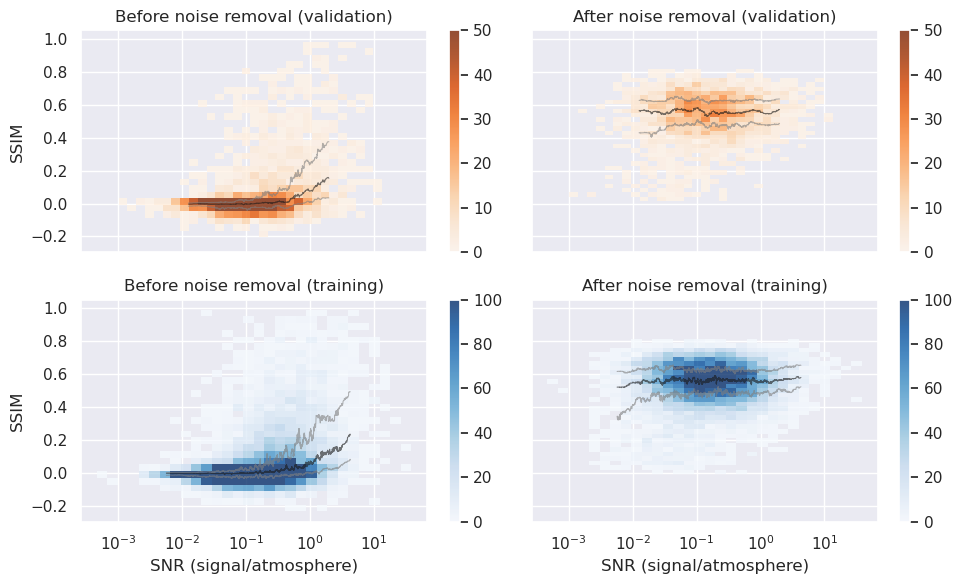

In [14]:
sns.set_theme()

f, ax = plt.subplots(2, 2, figsize=(10,6), sharex=True, sharey=True)

sns.histplot(ax=ax[0, 0], x=val_ssim_df.snr, y=val_ssim_df.ssim_uncorrected, cmap='Oranges', cbar=False, alpha=0)
ax[0][0].set_xscale('log')

sns.histplot(ax=ax[0, 0], x=val_ssim_df.snr, y=val_ssim_df.ssim_uncorrected, cmap='Oranges', cbar=True,
             bins=30, vmax=50, alpha=0.8)
ax[0][0].set_xscale('log')
ax[0][0].set_xlabel('SNR (signal/atmosphere)')
ax[0][0].set_ylabel('SSIM')
ax[0][0].set_title('Before noise removal (validation)')

sns.lineplot(ax=ax[0, 0], x=val_ssim_df.snr, y=val_ssim_df.ssim_uncorrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_ssim_df.snr, y=val_ssim_df.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_ssim_df.snr, y=val_ssim_df.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

sns.histplot(ax=ax[0, 1], x=val_ssim_df.snr, y=val_ssim_df.ssim_corrected, cmap='Oranges', cbar=True,
             bins=30, vmax=50, alpha=0.8)
ax[0][1].set_xscale('log')
ax[0][1].set_xlabel('SNR (signal/atmosphere)')
ax[0][1].set_title('After noise removal (validation)')

sns.lineplot(ax=ax[0, 1], x=val_ssim_df.snr, y=val_ssim_df.ssim_corrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_ssim_df.snr, y=val_ssim_df.ssim_corrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_ssim_df.snr, y=val_ssim_df.ssim_corrected_q75, size=1, c='gray', legend=False, alpha=0.6)

sns.histplot(ax=ax[1, 0], x=train_ssim_df.snr, y=train_ssim_df.ssim_uncorrected, cmap='Blues', cbar=True, 
             bins=30, vmax=100, alpha=0.8)
ax[1][0].set_xscale('log')
ax[1][0].set_xlabel('SNR (signal/atmosphere)')
ax[1][0].set_ylabel('SSIM')
ax[1][0].set_title('Before noise removal (training)')

sns.lineplot(ax=ax[1, 0], x=train_ssim_df.snr, y=train_ssim_df.ssim_uncorrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_ssim_df.snr, y=train_ssim_df.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_ssim_df.snr, y=train_ssim_df.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

sns.histplot(ax=ax[1, 1], x=train_ssim_df.snr, y=train_ssim_df.ssim_corrected, cmap='Blues', cbar=True, 
             bins=30, vmax=100, alpha=0.8)
ax[1][1].set_xscale('log')
ax[1][1].set_xlabel('SNR (signal/atmosphere)')
ax[1][1].set_title('After noise removal (training)')
f.tight_layout()

sns.lineplot(ax=ax[1, 1], x=train_ssim_df.snr, y=train_ssim_df.ssim_corrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_ssim_df.snr, y=train_ssim_df.ssim_corrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_ssim_df.snr, y=train_ssim_df.ssim_corrected_q75, size=1, c='gray', legend=False, alpha=0.6)

#plt.savefig('SSIMv1.png', dpi=300)

## ERA5 correction

In [15]:
val_data_era5 = dataset(val_list, signal_dir, noise_dir, dem_dir, era5_dir, transform=my_transforms, invert=False, blurnoise=True, era5_corr=True)
val_loader_era5 = torch.utils.data.DataLoader(dataset = val_data_era5, batch_size=1, shuffle=False)

# Calculate SSIM
val_ssim_era5_list_corrected = []
val_ssim_era5_list_uncorrected = []

for i, (sample, signal_target, noise_target, era5_noise, dem) in enumerate(val_loader_era5):
    val_corrected = era5_noise
    val_ssim_value_corrected = ssim(val_corrected.squeeze().numpy(), signal_target.squeeze().numpy(),
                         gaussian_weights=True)
    val_ssim_era5_list_corrected.append(val_ssim_value_corrected)
    val_ssim_value_uncorrected = ssim(sample.squeeze().numpy(), signal_target.squeeze().numpy(),
                         gaussian_weights=True)
    val_ssim_era5_list_uncorrected.append(val_ssim_value_uncorrected)
    
    
print('mean val ssim (before correction):', np.mean(val_ssim_era5_list_uncorrected),
      '\nmean val ssim (after correction):', np.mean(val_ssim_era5_list_corrected))

train_data_era5 = dataset(train_list, signal_dir, noise_dir, dem_dir, era5_dir, transform=my_transforms, invert=False, blurnoise=True, era5_corr=True)
train_loader_era5 = torch.utils.data.DataLoader(dataset = train_data_era5, batch_size=1, shuffle=False)

train_ssim_era5_list_corrected = []
train_ssim_era5_list_uncorrected = []

for i, (sample, signal_target, noise_target, era5_noise, dem) in enumerate(train_loader_era5):
    train_corrected = era5_noise
    train_ssim_value_corrected = ssim(train_corrected.squeeze().numpy(), signal_target.squeeze().numpy(),
                         gaussian_weights=True)
    train_ssim_era5_list_corrected.append(train_ssim_value_corrected)
    train_ssim_value_uncorrected = ssim(sample.squeeze().numpy(), signal_target.squeeze().numpy(),
                         gaussian_weights=True)
    train_ssim_era5_list_uncorrected.append(train_ssim_value_uncorrected)
    
    
print('mean train ssim (before correction):', np.mean(train_ssim_era5_list_uncorrected),
      '\nmean train ssim (after correction):', np.mean(train_ssim_era5_list_corrected)) 

mean val ssim (before correction): 0.05035375858463773 
mean val ssim (after correction): 0.2955823047021846
mean train ssim (before correction): 0.05472665643653551 
mean train ssim (after correction): 0.2970398649115536


In [16]:
# Calculate SNR
def rms(tensor):
    rms = np.sqrt(np.mean(tensor.squeeze().numpy()**2))
    return rms

val_era5_snr_list = []

for i, (sample, signal_target, noise_target, era5_noise, dem) in enumerate(val_loader_era5):
    val_era5_snr_list.append(rms(signal_target)/rms(sample-signal_target))
    

print('mean snr of val images:', np.mean(val_era5_snr_list)) 

train_era5_snr_list = []

for i, (sample, signal_target, noise_target, era5_noise, dem) in enumerate(train_loader_era5):
    train_era5_snr_list.append(rms(signal_target)/rms(sample-signal_target))
    

print('mean snr of train images:', np.mean(train_era5_snr_list)) 

mean snr of val images: 0.40184352
mean snr of train images: 0.40087935


In [17]:
val_era5_ssim_dict = {'snr': val_era5_snr_list,
                 'ssim_uncorrected': val_ssim_era5_list_uncorrected,
                 'ssim_corrected':val_ssim_era5_list_corrected}
val_era5_ssim_df = pd.DataFrame(val_era5_ssim_dict)
val_era5_ssim_df['ssim_uncorrected_median'] = val_era5_ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(200, center=True).median()
val_era5_ssim_df['ssim_corrected_median'] = val_era5_ssim_df.sort_values(by=['snr']).ssim_corrected.rolling(200, center=True).median()
val_era5_ssim_df['ssim_uncorrected_q25'] = val_era5_ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(200, center=True).quantile(quantile=0.25)
val_era5_ssim_df['ssim_corrected_q25'] = val_era5_ssim_df.sort_values(by=['snr']).ssim_corrected.rolling(200, center=True).quantile(quantile=0.25)
val_era5_ssim_df['ssim_uncorrected_q75'] = val_era5_ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(200, center=True).quantile(quantile=0.75)
val_era5_ssim_df['ssim_corrected_q75'] = val_era5_ssim_df.sort_values(by=['snr']).ssim_corrected.rolling(200, center=True).quantile(quantile=0.75)

train_era5_ssim_dict = {'snr':train_era5_snr_list,
                   'ssim_uncorrected':train_ssim_era5_list_uncorrected,
                   'ssim_corrected':train_ssim_era5_list_corrected}
train_era5_ssim_df = pd.DataFrame(train_era5_ssim_dict)
train_era5_ssim_df['ssim_uncorrected_median'] = train_era5_ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(200, center=True).median()
train_era5_ssim_df['ssim_corrected_median'] = train_era5_ssim_df.sort_values(by=['snr']).ssim_corrected.rolling(200, center=True).median()
train_era5_ssim_df['ssim_uncorrected_q25'] = train_era5_ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(200, center=True).quantile(quantile=0.25)
train_era5_ssim_df['ssim_corrected_q25'] = train_era5_ssim_df.sort_values(by=['snr']).ssim_corrected.rolling(200, center=True).quantile(quantile=0.25)
train_era5_ssim_df['ssim_uncorrected_q75'] = train_era5_ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(200, center=True).quantile(quantile=0.75)
train_era5_ssim_df['ssim_corrected_q75'] = train_era5_ssim_df.sort_values(by=['snr']).ssim_corrected.rolling(200, center=True).quantile(quantile=0.75)

<AxesSubplot:title={'center':'After noise removal (training)'}, xlabel='SNR (signal/atmosphere)', ylabel='ssim_corrected'>

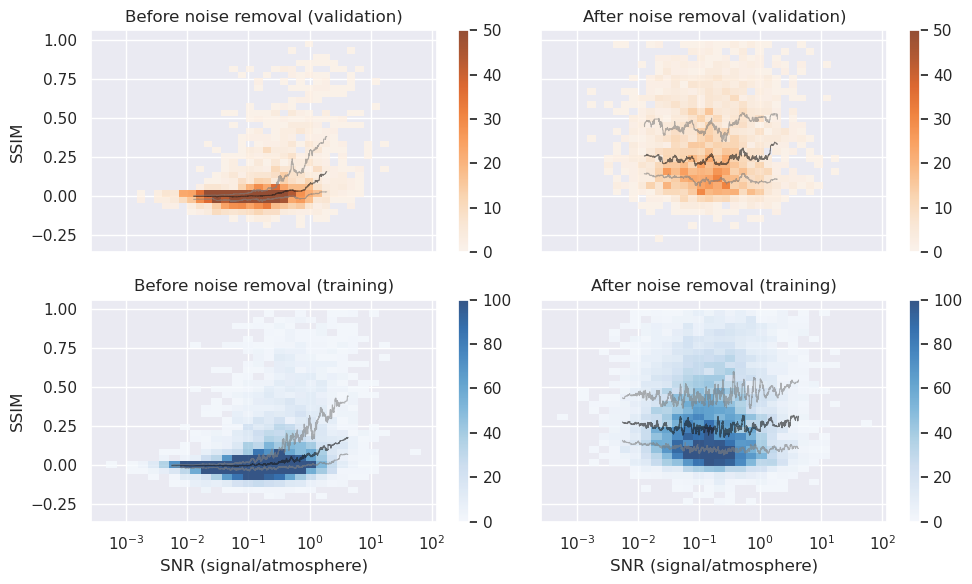

In [18]:
sns.set_theme()

f, ax = plt.subplots(2, 2, figsize=(10,6), sharex=True, sharey=True)

sns.histplot(ax=ax[0, 0], x=val_era5_ssim_df.snr, y=val_era5_ssim_df.ssim_uncorrected, cmap='Oranges', cbar=False, alpha=0)
ax[0][0].set_xscale('log')

sns.histplot(ax=ax[0, 0], x=val_era5_ssim_df.snr, y=val_era5_ssim_df.ssim_uncorrected, cmap='Oranges', cbar=True,
             bins=30, vmax=50, alpha=0.8)
ax[0][0].set_xscale('log')
ax[0][0].set_xlabel('SNR (signal/atmosphere)')
ax[0][0].set_ylabel('SSIM')
ax[0][0].set_title('Before noise removal (validation)')

sns.lineplot(ax=ax[0, 0], x=val_era5_ssim_df.snr, y=val_era5_ssim_df.ssim_uncorrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_era5_ssim_df.snr, y=val_era5_ssim_df.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_era5_ssim_df.snr, y=val_era5_ssim_df.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

sns.histplot(ax=ax[0, 1], x=val_era5_ssim_df.snr, y=val_era5_ssim_df.ssim_corrected, cmap='Oranges', cbar=True,
             bins=30, vmax=50, alpha=0.8)
ax[0][1].set_xscale('log')
ax[0][1].set_xlabel('SNR (signal/atmosphere)')
ax[0][1].set_title('After noise removal (validation)')

sns.lineplot(ax=ax[0, 1], x=val_era5_ssim_df.snr, y=val_era5_ssim_df.ssim_corrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_era5_ssim_df.snr, y=val_era5_ssim_df.ssim_corrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_era5_ssim_df.snr, y=val_era5_ssim_df.ssim_corrected_q75, size=1, c='gray', legend=False, alpha=0.6)

sns.histplot(ax=ax[1, 0], x=train_era5_ssim_df.snr, y=train_era5_ssim_df.ssim_uncorrected, cmap='Blues', cbar=True, 
             bins=30, vmax=100, alpha=0.8)
ax[1][0].set_xscale('log')
ax[1][0].set_xlabel('SNR (signal/atmosphere)')
ax[1][0].set_ylabel('SSIM')
ax[1][0].set_title('Before noise removal (training)')

sns.lineplot(ax=ax[1, 0], x=train_era5_ssim_df.snr, y=train_era5_ssim_df.ssim_uncorrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_era5_ssim_df.snr, y=train_era5_ssim_df.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_era5_ssim_df.snr, y=train_era5_ssim_df.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

sns.histplot(ax=ax[1, 1], x=train_era5_ssim_df.snr, y=train_era5_ssim_df.ssim_corrected, cmap='Blues', cbar=True, 
             bins=30, vmax=100, alpha=0.8)
ax[1][1].set_xscale('log')
ax[1][1].set_xlabel('SNR (signal/atmosphere)')
ax[1][1].set_title('After noise removal (training)')
f.tight_layout()

sns.lineplot(ax=ax[1, 1], x=train_era5_ssim_df.snr, y=train_era5_ssim_df.ssim_corrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_era5_ssim_df.snr, y=train_era5_ssim_df.ssim_corrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_era5_ssim_df.snr, y=train_era5_ssim_df.ssim_corrected_q75, size=1, c='gray', legend=False, alpha=0.6)

#plt.savefig('SSIMv1.png', dpi=300)

## Visualize feature maps

In [ ]:
# visualize feature maps

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

cnn_names = ['cnn1', 'cnn2', 'cnn3','cnn4','cnn5', 'cnn6', 'cnn7', 'cnn8'] 
cnn_vars = [model.cnn1, model.cnn2, model.cnn3, model.cnn4, model.cnn5,
            model.cnn6, model.cnn7, model.cnn8]


def plot_feature(cnn_vars, cnn_names, num_images=1):
    for i, (sample, signal_target, noise_target, dem) in enumerate(val_loader):
        if i<num_images:
            for j, cnn_name in enumerate(cnn_names):
                cnn = cnn_vars[j]
                cnn.register_forward_hook(get_activation(cnn_name))
                output = model(sample.to('cuda'), dem.to('cuda'))

                act = activation[cnn_name].squeeze()
                act1 = act[0:15,:,:].sum(dim=0, keepdim=True).squeeze()
                act2 = act[16:31,:,:].sum(dim=0, keepdim=True).squeeze()
                act3 = act[32:47,:,:].sum(dim=0, keepdim=True).squeeze()
                act4 = act[48:63,:,:].sum(dim=0, keepdim=True).squeeze()

                fig, ax = plt.subplots(1, 5, figsize=(19,5))
                #ax[0].imshow(dem.squeeze().to('cpu'), cmap='Greys')
                ax[0].imshow(sample.squeeze().to('cpu'), cmap='RdBu')
                ax[0].set_title('original image')
                ax[1].imshow(act1.to('cpu'))
                ax[1].set_title(f'{cnn_name} feature map')
                ax[2].imshow(act2.to('cpu'))
                ax[2].set_title(f'{cnn_name} feature map')
                ax[3].imshow(act3.to('cpu'))
                ax[3].set_title(f'{cnn_name} feature map')
                ax[4].imshow(act4.to('cpu'))
                ax[4].set_title(f'{cnn_name} feature map')
        else:
            break
            
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=1, shuffle=True)

In [ ]:
plot_feature(cnn_vars, cnn_names, num_images=1)